<a href="https://colab.research.google.com/github/StevenHolmberg/CSE5683/blob/main/Camera_Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import cv2 as cv
from  matplotlib import pyplot as plt
from scipy.optimize import fsolve, root

import io
import PIL
import requests

from PIL import Image
import glob
import os
from matplotlib.widgets import Button
import scipy
import plotly.graph_objects as go

In [6]:
# Model corners (features detected on the model)
modelCorners = np.float32([[0,0],[216,0],[216,279],[0,279]])
modelCorners = modelCorners.T;
print("Model points =\n", modelCorners)

Model points =
 [[  0. 216. 216.   0.]
 [  0.   0. 279. 279.]]


In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


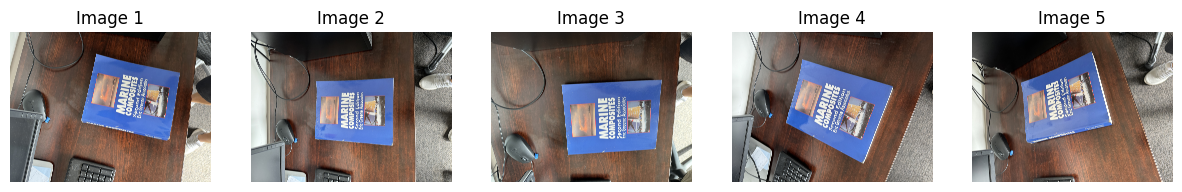

In [8]:
# Define the folder path
video_path = '/content/drive/MyDrive/AdvancedComputerVision/Assignment6_images/'

# Get a list of all JPEG images in the folder
image_paths = glob.glob(os.path.join(video_path, "*.jpeg"))  # Use "*.jpeg" if needed

# Check if exactly 5 images are found
if len(image_paths) != 5:
    print(f"Expected 5 images, but found {len(image_paths)}.")
else:
    # Open and store images in a list
    images = [Image.open(img_path) for img_path in image_paths]

    # Plot all 5 images
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(images):
        plt.subplot(1, 5, i + 1)  # Arrange images in a single row
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i + 1}")
    plt.show()


(5712, 4284)


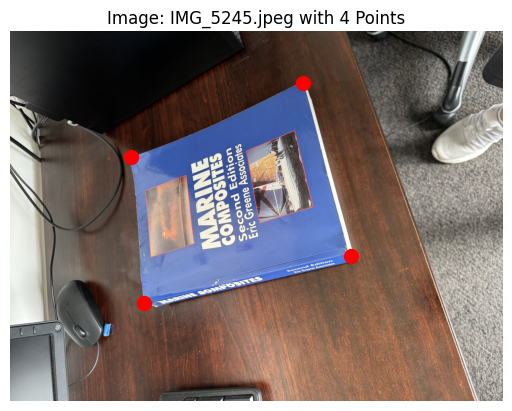

In [9]:
# Define the folder path
video_path = '/content/drive/MyDrive/AdvancedComputerVision/Assignment6_images/'

# Get the list of .jpeg files in the directory
image_files = [f for f in os.listdir(video_path) if f.endswith('.jpeg')]
imageNum = 4
# Check if there are any images in the directory
if not image_files:
    print("No .jpeg images found in the directory.")
else:
    # Load the first image in the list
    image_path = os.path.join(video_path, image_files[imageNum])
    image = Image.open(image_path)

    print(image.size)

    # Define the 4 points you want to plot (x, y) coordinates
    points = [(1550, 3150), (1400, 1450), (3400, 600), (3950, 2600)]  # Replace with your actual points

    # Plot the image and the points
    plt.imshow(image)
    plt.scatter(*zip(*points), color='red', s=100)  # Plot all points in red
    plt.title(f"Image: {image_files[0]} with 4 Points")
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()


In [10]:
# Define the 4 points you want to plot (x, y) coordinates
image1_points = np.float32([(2050, 2500), (2450, 650), (4800, 1200), (4500, 3050)])
image2_points = np.float32([(1800, 3050), (1850, 1450), (4050, 1350), (4000, 3250)])
image3_points = np.float32([(2200, 3500), (2000, 1550), (4850, 1400), (4700, 3350)])
image4_points = np.float32([(1550, 2600), (2000, 850), (4500, 1600), (3700, 3700)])
image5_points = np.float32([(1550, 3150), (1400, 1450), (3400, 600), (3950, 2600)])
image_points = [image1_points, image2_points, image3_points, image4_points, image5_points]

In [11]:
# Using the OpenCV functions
# Function cv.getPerspectiveTransform expects row vectors, not column vectors
Phi1 = cv.getPerspectiveTransform(image1_points,modelCorners.T)
Phi2 = cv.getPerspectiveTransform(image2_points,modelCorners.T)
Phi3 = cv.getPerspectiveTransform(image3_points,modelCorners.T)
Phi4 = cv.getPerspectiveTransform(image4_points,modelCorners.T)
Phi5 = cv.getPerspectiveTransform(image5_points,modelCorners.T)
print("Homography (Phi) matrix = \n", Phi1)
Phi = [Phi1, Phi2, Phi3, Phi4, Phi5]

Homography (Phi) matrix = 
 [[ 2.47369566e-02 -1.10191898e-01  2.24768983e+02]
 [ 1.10533518e-01  2.38991389e-02 -2.86341558e+02]
 [-9.52387962e-06  1.98705861e-05  1.00000000e+00]]


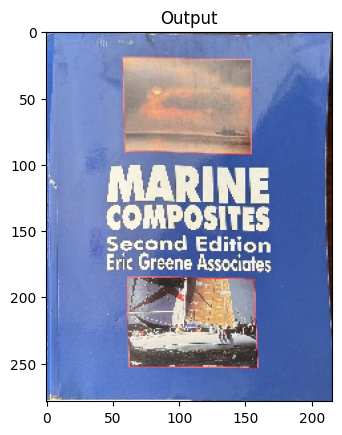

In [12]:
image_np = np.array(image)
dstImage = cv.warpPerspective(image_np,Phi[imageNum],(216,279))
plt.imshow(dstImage)
plt.title('Output')
plt.show()

In [13]:
# Function to orthogonalize and normalize a matrix
def orthonormalize(matrix):
    # Gram-Schmidt process
    u1 = matrix[:, 0]
    u2 = matrix[:, 1] - np.dot(matrix[:, 1], u1) / np.dot(u1, u1) * u1
    u3 = matrix[:, 2] - np.dot(matrix[:, 2], u1) / np.dot(u1, u1) * u1 - np.dot(matrix[:, 2], u2) / np.dot(u2, u2) * u2

    # Normalize the vectors
    u1 /= np.linalg.norm(u1)
    u2 /= np.linalg.norm(u2)
    u3 /= np.linalg.norm(u3)

    return np.column_stack((u1, u2, u3))

In [14]:
# Intrinsic Matrix
K = np.array([[3.72233765e+03, 0.0, 2.07977894e+03],
              [0.0, 3.74341843e+03, 2.95419856e+03],
              [0.0, 0.0, 1.0]],float)
K_inv = np.linalg.inv(K)

i = 1

phi_prime = K_inv @ Phi[i]
phi_prime = cv.normalize(phi_prime,phi_prime)

# Extract the rotation and translation components
r1 = phi_prime[:, 0]/np.linalg.norm(phi_prime[:, 0])
r2 = phi_prime[:, 1]/np.linalg.norm(phi_prime[:, 1])
t = phi_prime[:, 2]
r12 = phi_prime[:,0:2]

if np.dot(r1,r2) > 10e-5:
  print("Vectors not orthogonal: " + str(np.dot(r1,r2)))

# Form the rotation matrix
r3 = np.cross(r1,r2)
R = np.column_stack((r1, r2, r3))
R = orthonormalize(R)  # Normalize to unit length (if needed)
# print(np.linalg.norm(R[0,:]))

lambda_phi = np.mean(R[:,0:2] / r12)
t = t/lambda_phi * 1000
print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)

Vectors not orthogonal: 0.5644512601821218
Rotation Matrix R:
 [[-0.44426443 -0.89545999  0.02793798]
 [-0.27039716  0.1042915  -0.95708341]
 [ 0.85411621 -0.43275246 -0.28846284]]
Translation Vector t:
 [ 0.02116934  0.04297506 -0.04880489]


In [15]:
# Decompose homography to obtain rotation and translation

# Intrinsic Matrix
K = np.array([[3.72233765e+03, 0.0, 2.07977894e+03],
              [0.0, 3.74341843e+03, 2.95419856e+03],
              [0.0, 0.0, 1.0]],float)

# This will return several possible solutions
retval, R_list, t_list, normals = cv.decomposeHomographyMat(Phi[0], K)

R = R_list[0]
t = t_list[0].T

print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)

Rotation Matrix R:
 [[-0.23933874 -0.80590659 -0.54150858]
 [ 0.36515528  0.44206045 -0.81929493]
 [ 0.8996547  -0.39382374  0.18847885]]
Translation Vector t:
 [[-4.83103929 -6.56441322  9.22447475]]


In [16]:
import numpy as np

# Example intrinsic matrix
K = np.array([[3.72233765e+03, 0.0, 2.07977894e+03],
              [0.0, 3.74341843e+03, 2.95419856e+03],
              [0.0, 0.0, 1.0]], float)
K_inv = np.linalg.inv(K)

# Sample Phi matrix (make sure this is defined correctly)
# Phi = ...

i = 1

phi_prime = K_inv @ Phi[i]

# Extract the rotation and translation components
r1 = phi_prime[:, 0] / np.linalg.norm(phi_prime[:, 0])
r2 = phi_prime[:, 1] / np.linalg.norm(phi_prime[:, 1])
t = phi_prime[:, 2]
r12 = phi_prime[:, 0:2]

if np.dot(r1, r2) > 10e-5:
    print("Vectors not orthogonal: " + str(np.dot(r1, r2)))

# Using SVD to enforce orthogonality
# Create a 2x2 matrix from r1 and r2
A = np.column_stack((r1, r2))

# Perform SVD
U, _, Vt = np.linalg.svd(A)

# Reconstruct r1 and r2 to be orthogonal and normalized
r1_orthogonal = U[:, 0]
r2_orthogonal = U[:, 1]

# Ensure r2 is in the same direction as the original r2
if np.dot(r1_orthogonal, r2) < 0:
    r2_orthogonal = -r2_orthogonal

# Form the rotation matrix
r3 = np.cross(r1_orthogonal, r2_orthogonal)
R = np.column_stack((r1_orthogonal, r2_orthogonal, r3))
R = orthonormalize(R)  # Normalize to unit length (if needed)

lambda_phi = np.mean(R[:, 0:2] / r12)
t = t / lambda_phi * 10e6  # Convert to millimeters

print("Rotation Matrix R:\n", R)
print("Translation Vector t:\n", t)


Vectors not orthogonal: 0.5644512601821219
Rotation Matrix R:
 [[-0.81080116  0.58465456 -0.02793798]
 [-0.19047978 -0.21842342  0.95708341]
 [ 0.55346087  0.78132596  0.28846284]]
Translation Vector t:
 [-120.0570785  -243.72322262  276.78579653]


In [17]:
# Check orthonormality
if np.allclose(np.dot(R.T, R), np.eye(3)) and np.allclose(np.linalg.det(R), 1):
    print("R is a valid rotation matrix.")
else:
    print("R is not a valid rotation matrix.")

R is a valid rotation matrix.


In [18]:
!pip install pytransform3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 54.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pytransform3d: filename=pytransform3d-3.8.0-py3-none-any.whl size=134564 sha256=4ad9d3b4d521f8893548354e94ff347338ee22fdb9cf4855f9b3bdf427ed7d70
  Stored in directory: /root/.cache/pip/wheels/88/c0/02/704eb9f411d1b6aa4304b6f56ec38c439b817b0f1dde3297a0
Successfully built pytransform3d


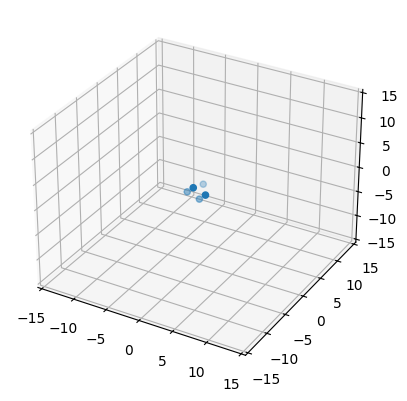

In [19]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Original vertices of the pyramid
v = np.array([[-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1], [0, 0, 1]])

# Apply the rotation matrix to each vertex
v_rotated = v @ R.T  # Transpose R for correct dimension alignment

# Apply translation
v_translated = v_rotated + t

# Define the pyramid faces with transformed vertices
verts = [
    [v_translated[0], v_translated[1], v_translated[4]],
    [v_translated[0], v_translated[3], v_translated[4]],
    [v_translated[2], v_translated[1], v_translated[4]],
    [v_translated[2], v_translated[3], v_translated[4]],
    [v_translated[0], v_translated[1], v_translated[2], v_translated[3]]
]

# Create a Plotly figure
fig = go.Figure()

# Add the pyramid sides
for vert in verts:
    # Create a 3D polygon for each face
    fig.add_trace(go.Mesh3d(
        x=[v[0] for v in vert],
        y=[v[1] for v in vert],
        z=[v[2] for v in vert],
        color='cyan',
        opacity=0.5
    ))

# Add the vertices as points
fig.add_trace(go.Scatter3d(
    x=v_translated[:, 0],
    y=v_translated[:, 1],
    z=v_translated[:, 2],
    mode='markers',
    marker=dict(size=5, color='red')
))
scale = 15

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-scale, scale]),
        yaxis=dict(nticks=4, range=[-scale, scale]),
        zaxis=dict(nticks=4, range=[-scale, scale])
    ),
    width=700,
    height=700,
    margin=dict(l=0, r=0, b=0, t=0)
)

# Show the Plotly figure
fig.show()

# Now set up the Matplotlib 3D plot
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')

# Scatter plot for the rotated vertices
ax.scatter3D(v_rotated[:, 0], v_rotated[:, 1], v_rotated[:, 2])

# Plot sides of the rotated pyramid
ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.25))

# Set axis limits for better visibility
ax.set_xlim([-scale, scale])
ax.set_ylim([-scale, scale])
ax.set_zlim([-scale, scale])

plt.show()


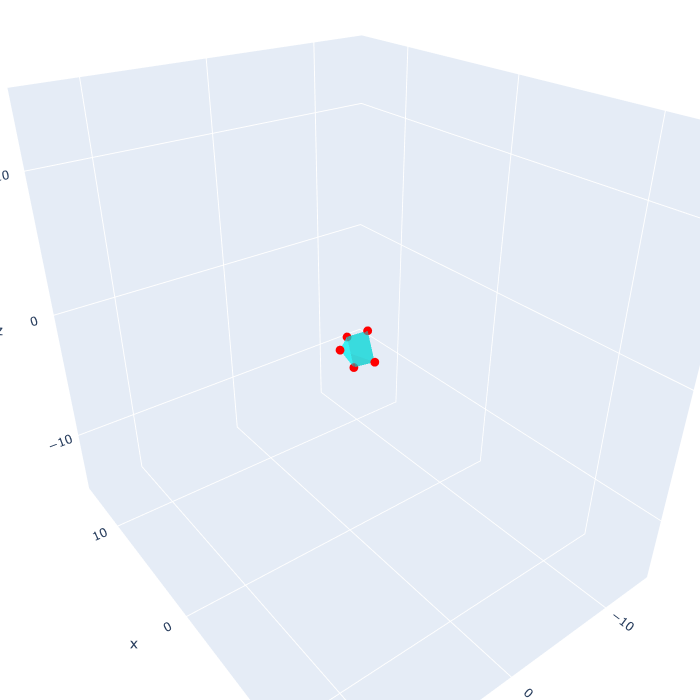

In [20]:
import numpy as np
import plotly.graph_objects as go

# Intrinsic Matrix
K = np.array([[3.72233765e+03, 0.0, 2.07977894e+03],
              [0.0, 3.74341843e+03, 2.95419856e+03],
              [0.0, 0.0, 1.0]], float)
K_inv = np.linalg.inv(K)

# Store transformed vertices and camera positions
all_verts = []
all_translations = []

# Iterate over the camera poses
for i in range(len(Phi)):

    # Example intrinsic matrix
    K = np.array([[3.72233765e+03, 0.0, 2.07977894e+03],
                  [0.0, 3.74341843e+03, 2.95419856e+03],
                  [0.0, 0.0, 1.0]], float)
    K_inv = np.linalg.inv(K)

    phi_prime = K_inv @ Phi[i]

    # Extract the rotation and translation components
    r1 = phi_prime[:, 0] / np.linalg.norm(phi_prime[:, 0])
    r2 = phi_prime[:, 1] / np.linalg.norm(phi_prime[:, 1])
    t = phi_prime[:, 2]
    r12 = phi_prime[:, 0:2]

    if np.dot(r1, r2) > 10e-5:
        print("Vectors not orthogonal: " + str(np.dot(r1, r2)))

    # Using SVD to enforce orthogonality
    # Create a 2x2 matrix from r1 and r2
    A = np.column_stack((r1, r2))

    # Perform SVD
    U, _, Vt = np.linalg.svd(A)

    # Reconstruct r1 and r2 to be orthogonal and normalized
    r1_orthogonal = U[:, 0]
    r2_orthogonal = U[:, 1]

    # Ensure r2 is in the same direction as the original r2
    if np.dot(r1_orthogonal, r2) < 0:
        r2_orthogonal = -r2_orthogonal

    # Form the rotation matrix
    r3 = np.cross(r1_orthogonal, r2_orthogonal)
    R = np.column_stack((r1_orthogonal, r2_orthogonal, r3))
    R = orthonormalize(R)  # Normalize to unit length (if needed)

    lambda_phi = np.mean(R[:, 0:2] / r12)
    t = t / lambda_phi * 10e6  # Convert to millimeters

    print(t)

    # Original vertices of the pyramid
    v = np.array([[-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1], [0, 0, 1]])*200

    # Apply the rotation matrix to each vertex
    v_rotated = v @ R  # Transpose R for correct dimension alignment
    # Apply translation
    v_translated = v_rotated + t

    # Store the transformed vertices and translation
    all_verts.append(v_translated)
    all_translations.append(t)

# Create a Plotly figure for all cameras
fig = go.Figure()

# Add each pyramid for the cameras
for v_translated in all_verts:
    # Define the pyramid faces with transformed vertices
    verts = [[v_translated[0], v_translated[1], v_translated[4]],
             [v_translated[0], v_translated[3], v_translated[4]],
             [v_translated[2], v_translated[1], v_translated[4]],
             [v_translated[2], v_translated[3], v_translated[4]],
             [v_translated[0], v_translated[1], v_translated[2], v_translated[3]]]

    # Add the pyramid sides
    for vert in verts:
        # Create a 3D polygon for each face
        fig.add_trace(go.Mesh3d(
            x=[v[0] for v in vert],
            y=[v[1] for v in vert],
            z=[v[2] for v in vert],
            color='cyan',
            opacity=0.5
        ))

# Add the vertices as points for each camera
for v_translated in all_verts:
    fig.add_trace(go.Scatter3d(
        x=v_translated[:, 0],
        y=v_translated[:, 1],
        z=v_translated[:, 2],
        mode='markers',
        marker=dict(size=5, color='red')
    ))

scale = 4500
# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-scale, scale]),
        yaxis=dict(nticks=4, range=[-scale, scale]),
        zaxis=dict(nticks=4, range=[-scale, scale])
    ),
    width=700,
    height=700,
    margin=dict(l=0, r=0, b=0, t=0),
    title="3D Visualization of Cameras and Pyramids"
)


# Model corners (features detected on the model)
modelCorners = np.float32([[0,0,0],[216,0,0],[216,279,0],[0,279,0]])*1000
# Define the square face with the transformed corners
square_verts = [modelCorners[0], modelCorners[1], modelCorners[2], modelCorners[3]]

# Create a 3D polygon for the square face
fig.add_trace(go.Mesh3d(
    x=[v[0] for v in square_verts],
    y=[v[1] for v in square_verts],
    z=[v[2] for v in square_verts],
    color='magenta',  # You can change the color as needed
    opacity=0.5
))

# Show the figure
fig.show()


[  532.2931615    924.63309721 -1068.1208844 ]
Vectors not orthogonal: 0.5644512601821219
[-120.0570785  -243.72322262  276.78579653]
Vectors not orthogonal: 0.76090635319901
[ 179.14946597  322.52343781 -387.73562512]
[ -781.15548391 -1410.12306616  1588.62066079]
Vectors not orthogonal: 0.9650149993874972
[-1480.11956824 -3296.63435869  3791.17010156]


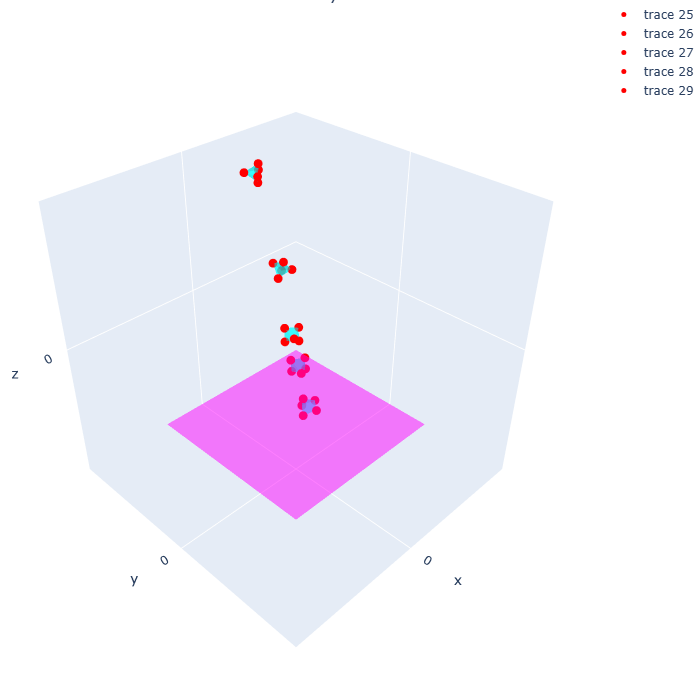

In [26]:
import numpy as np
import plotly.graph_objects as go

# Intrinsic Matrix
K = np.array([[3.72233765e+03, 0.0, 2.07977894e+03],
              [0.0, 3.74341843e+03, 2.95419856e+03],
              [0.0, 0.0, 1.0]], float)
K_inv = np.linalg.inv(K)

# Store transformed vertices and camera positions
all_verts = []
all_translations = []

# Iterate over the camera poses
for i in range(len(Phi)):

    # This will return several possible solutions
    retval, R_list, t_list, normals = cv.decomposeHomographyMat(Phi[i], K)

    R = R_list[0].T
    t = t_list[0].T @ R.T

    # Original vertices of the pyramid
    v = np.array([[-1, -1, -1], [1, -1, -1], [1, 1, -1], [-1, 1, -1], [0, 0, 1]])

    # Apply the rotation matrix to each vertex
    v_rotated = v @ R # Transpose R for correct dimension alignment
    # Apply translation
    v_translated = v_rotated + t

    # Store the transformed vertices and translation
    all_verts.append(v_translated)
    all_translations.append(t)

# Create a Plotly figure for all cameras
fig = go.Figure()

# Add each pyramid for the cameras
for v_translated in all_verts:
    # Define the pyramid faces with transformed vertices
    verts = [[v_translated[0], v_translated[1], v_translated[4]],
             [v_translated[0], v_translated[3], v_translated[4]],
             [v_translated[2], v_translated[1], v_translated[4]],
             [v_translated[2], v_translated[3], v_translated[4]],
             [v_translated[0], v_translated[1], v_translated[2], v_translated[3]]]

    # Add the pyramid sides
    for vert in verts:
        # Create a 3D polygon for each face
        fig.add_trace(go.Mesh3d(
            x=[v[0] for v in vert],
            y=[v[1] for v in vert],
            z=[v[2] for v in vert],
            color='cyan',
            opacity=0.5
        ))

# Add the vertices as points for each camera
for v_translated in all_verts:
    fig.add_trace(go.Scatter3d(
        x=v_translated[:, 0],
        y=v_translated[:, 1],
        z=v_translated[:, 2],
        mode='markers',
        marker=dict(size=5, color='red')
    ))

scale = 15
# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis=dict(nticks=4, range=[-scale, scale]),
        yaxis=dict(nticks=4, range=[-scale, scale]),
        zaxis=dict(nticks=4, range=[-scale, scale])
    ),
    width=700,
    height=700,
    margin=dict(l=0, r=0, b=0, t=0),
    title="3D Visualization of Cameras and Pyramids"
)

# Model corners (features detected on the model)
modelCorners = np.float32([[0,0,0],[216,0,0],[216,279,0],[0,279,0]])
# Define the square face with the transformed corners
square_verts = [modelCorners[0], modelCorners[1], modelCorners[2], modelCorners[3]]

# Create a 3D polygon for the square face
fig.add_trace(go.Mesh3d(
    x=[v[0] for v in square_verts],
    y=[v[1] for v in square_verts],
    z=[v[2] for v in square_verts],
    color='magenta',  # You can change the color as needed
    opacity=0.5
))

# Show the figure
fig.show()


Attempt 1:

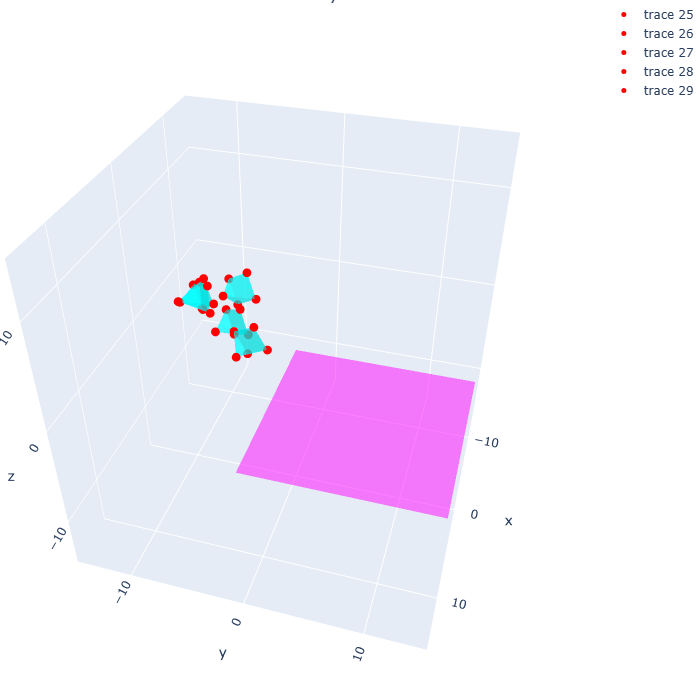

Corrected Rotation Matrix:
- likely a problem with the original plotting of the pyramid

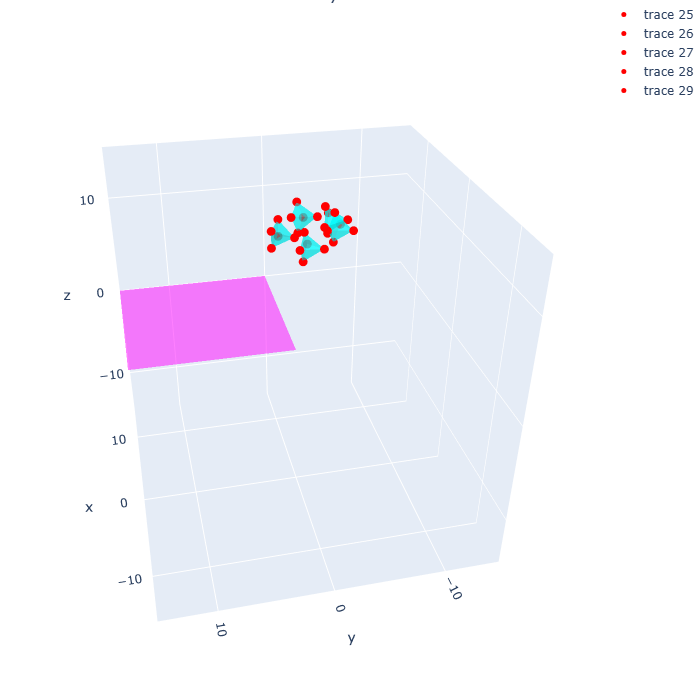